In [21]:
!pip install pyspark


In [22]:
!python -m pip install findspark

## Install All Necessary Packages


In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark = SparkSession.builder.getOrCreate()


### create Spark Session using Driver

In [24]:
# Open a session running data from PostgreSQL
spark_postgre = SparkSession \
    .builder \
    .appName("git_postgre") \
    .config("spark.jars", "/Users/Kamalpriyank/Downloads/postgresql-42.4.0.jar") \
    .getOrCreate()


In [25]:
spark_postgre


### Import Required Data From local Host of postgresql using the driver

In [26]:
# Read data from PostgreSQL running at localhost
params = spark_postgre.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/gitHubData") \
    .option("user", "postgres") \
    .option("password", "0793") \
    .option("driver", "org.postgresql.Driver")

df_issues = params \
    .option("dbtable", "issues") \
    .load()

df_commits = params \
    .option("dbtable", "commits") \
    .load()

df_projects = params \
    .option("dbtable", "projects") \
    .load()

df_users = params \
    .option("dbtable", "users") \
    .load()

df_comments = params \
    .option("dbtable", "comments") \
    .load()

df_timezone = params \
    .option("dbtable", "timezone") \
    .load()

df_issues.printSchema()
df_commits.printSchema()
df_projects.printSchema()
df_users.printSchema()
df_comments.printSchema()
df_timezone.printSchema()


root
 |-- id: integer (nullable = true)
 |-- project_id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- state: string (nullable = true)
 |-- body: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- repository: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- updated_at: timestamp (nullable = true)
 |-- closed_at: timestamp (nullable = true)
 |-- assignees: string (nullable = true)
 |-- labels: string (nullable = true)
 |-- reactions: string (nullable = true)
 |-- n_comments: short (nullable = true)
 |-- closed_by: string (nullable = true)
 |-- comment_id: integer (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- project_id: integer (nullable = true)
 |-- hash: string (nullable = true)
 |-- msg: string (nullable = true)
 |-- author_name: string (nullable = true)
 |-- committer_name: string (nullable = true)
 |-- author_date: timestamp (nullable = true)
 |-- author_timezone: string (nullable = true)
 |-- commi

### Removing any rows with Null Values

In [27]:
df_issues = df_issues.na.drop('any')

df_comments = df_comments.na.drop('any')

df_projects = df_projects.na.drop('any')

df_timezone = df_timezone.na.drop('any')

df_users = df_users.na.drop('any')


In [28]:
df_commits.printSchema()

root
 |-- id: integer (nullable = true)
 |-- project_id: integer (nullable = true)
 |-- hash: string (nullable = true)
 |-- msg: string (nullable = true)
 |-- author_name: string (nullable = true)
 |-- committer_name: string (nullable = true)
 |-- author_date: timestamp (nullable = true)
 |-- author_timezone: string (nullable = true)
 |-- committer_date: timestamp (nullable = true)
 |-- committer_timezone: string (nullable = true)
 |-- branches: string (nullable = true)
 |-- in_main_branch: string (nullable = true)
 |-- merge: string (nullable = true)
 |-- parents: string (nullable = true)
 |-- deletions: integer (nullable = true)
 |-- insertions: integer (nullable = true)
 |-- lines: integer (nullable = true)
 |-- files: short (nullable = true)
 |-- old_path: string (nullable = true)
 |-- new_path: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- change_type: string (nullable = true)
 |-- diff: string (nullable = true)
 |-- diff_parsed: string (nullable = true)
 |

In [29]:
df_commits = df_commits.na.drop(subset=['deletions','insertions','lines','token_count','deleted_lines','nloc','files'])

In [30]:
df_issues.describe('n_comments').show(10)

+-------+------------------+
|summary|        n_comments|
+-------+------------------+
|  count|             32329|
|   mean|11.603885056760184|
| stddev|11.712540197282323|
|    min|                 1|
|    max|                85|
+-------+------------------+



In [31]:
df_projects.show()

+----------+------------+
|project_id|project_name|
+----------+------------+
|         1|     pytorch|
|         2|  tensorflow|
+----------+------------+



In [32]:
df_issues.groupby('project_id').agg({'n_comments': 'mean'}).show()

+----------+------------------+
|project_id|   avg(n_comments)|
+----------+------------------+
|         1| 24.70596026490066|
|         2|10.961939063564683|
+----------+------------------+



In [33]:
df_commits.describe(['deletions','insertions','lines','token_count','deleted_lines','nloc','files']).show()

+-------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|        deletions|        insertions|             lines|       token_count|     deleted_lines|              nloc|             files|
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|            27768|             27768|             27768|             27768|             27768|             27768|             27768|
|   mean|477.3608110054739|1084.0144050705849|1561.3752160760587|10790.134903486027|18.121902909824257|1525.1166450590608|28.579552002304812|
| stddev| 2760.85298914042| 5575.704881111084| 7303.194255138591| 28923.32966774252|506.96857997281234| 4342.399379140707| 76.53580610928329|
|    min|                0|                 0|                 1|               0.0|                 0|               0.0|                 1|
|    m

In [34]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import ChiSquareTest,Summarizer
from pyspark.sql import Row

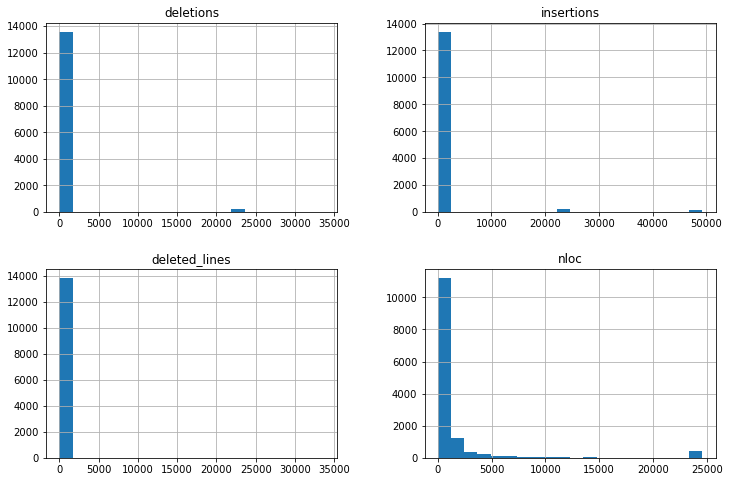

In [35]:
hist = df_commits.select(['deletions','insertions', "deleted_lines", "nloc"
                  ]) \
         .sample(False, 0.5, 123) \
         .toPandas() \
         .hist(bins=20,figsize=(12, 8))

In [91]:
df_commits_new = df_commits['deletions','insertions','lines','token_count','deleted_lines','nloc','files','change_type',"project_id"]

In [92]:
df_commits_new.describe()

DataFrame[summary: string, deletions: string, insertions: string, lines: string, token_count: string, deleted_lines: string, nloc: string, files: string, change_type: string, project_id: string]

### String indexing

In [93]:
# Applying some transformations: String indexer
from pyspark.ml.feature import StringIndexer

# Indexing 'clean_test'
idx_0 = StringIndexer().setInputCol("change_type").setOutputCol("change_type_idx")

# Indexing 'binary'
idx_1 = StringIndexer() \
        .setInputCol("project_id") \
        .setOutputCol("project_id_idx")

# Applying to df
df = idx_0.fit(df_commits_new).transform(df_commits_new)
df = idx_1.fit(df).transform(df)

# Inspect result
df.select(['project_id', 'project_id_idx','change_type', 'change_type_idx']).show()

+----------+--------------+-----------+---------------+
|project_id|project_id_idx|change_type|change_type_idx|
+----------+--------------+-----------+---------------+
|         2|           0.0|     MODIFY|            0.0|
|         2|           0.0|     MODIFY|            0.0|
|         2|           0.0|     MODIFY|            0.0|
|         2|           0.0|     MODIFY|            0.0|
|         2|           0.0|     MODIFY|            0.0|
|         2|           0.0|     MODIFY|            0.0|
|         2|           0.0|     MODIFY|            0.0|
|         2|           0.0|     MODIFY|            0.0|
|         2|           0.0|     MODIFY|            0.0|
|         2|           0.0|     MODIFY|            0.0|
|         2|           0.0|     MODIFY|            0.0|
|         2|           0.0|     MODIFY|            0.0|
|         2|           0.0|     MODIFY|            0.0|
|         2|           0.0|     MODIFY|            0.0|
|         2|           0.0|     MODIFY|         

### VectorAssembler for Feature Vectors

In [94]:
from pyspark.ml.feature import VectorAssembler

# Assembling a Vector for Logistic Regression
v_0 = VectorAssembler() \
    .setInputCols(["deletions", "insertions", "deleted_lines", "nloc","change_type_idx"]) \
    .setOutputCol('features_0')

# Assembling a Vector for Linear Regression
v_1 = VectorAssembler() \
    .setInputCols(["deleted_lines","nloc", "lines", "files","project_id_idx"]) \
    .setOutputCol('features_1')

# Applying
df = v_0.transform(df)
df = v_1.transform(df)

# show
df.select(['features_0', 'features_1']).show()


+--------------------+--------------------+
|          features_0|          features_1|
+--------------------+--------------------+
|[2.0,6.0,2.0,2479...|[2.0,2479.0,8.0,1...|
|[13.0,5.0,13.0,47...|[13.0,47.0,18.0,1...|
|[7.0,28.0,0.0,84....|[0.0,84.0,35.0,4....|
|[7.0,28.0,7.0,18....|[7.0,18.0,35.0,4....|
|[7.0,28.0,0.0,349...|[0.0,349.0,35.0,4...|
|(5,[1,3],[14.0,95...|[0.0,950.0,14.0,1...|
|(5,[1,3],[8.0,124...|[0.0,1242.0,8.0,1...|
|(5,[1,3],[5.0,153...|[0.0,1538.0,5.0,1...|
|[24.0,24.0,24.0,2...|[24.0,24041.0,48....|
|[204.0,438.0,179....|[179.0,2191.0,642...|
|[204.0,438.0,21.0...|[21.0,667.0,642.0...|
|[204.0,438.0,0.0,...|[0.0,4904.0,642.0...|
|[204.0,438.0,0.0,...|[0.0,278.0,642.0,...|
|[204.0,438.0,0.0,...|[0.0,6917.0,642.0...|
|[204.0,438.0,0.0,...|[0.0,890.0,642.0,...|
|[204.0,438.0,4.0,...|[4.0,1081.0,642.0...|
|[19.0,251.0,19.0,...|[19.0,522.0,270.0...|
|[67.0,95.0,25.0,1...|[25.0,1752.0,162....|
|[67.0,95.0,42.0,1...|[42.0,1247.0,162....|
|[1.0,1.0,1.0,46.0...|[1.0,46.0,

### Train and Test Split

In [95]:
# splitting training and test
train, test = df.randomSplit([0.7, 0.3])


### Linear Regression

In [96]:
from pyspark.ml.regression import LinearRegression

# instance of Linear Regression
lr_1 = LinearRegression(labelCol="change_type_idx",featuresCol="features_1")

# let's inspect parameters
a = lr_1.explainParams().split('\n')
x = 1
for i in a:
    b = i.split(':',1)
    b_0,b_1 = '\033[1m' + b[0] + '\033[0m', b[1]
    print("""{}. {} : {}
    """.format(x, b_0,b_1), flush=True)
    x=x+1

# fit
fitLr_1 = lr_1.fit(train)


1. aggregationDepth :  suggested depth for treeAggregate (>= 2). (default: 2)
    
2. elasticNetParam :  the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
    
3. epsilon :  The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber (default: 1.35)
    
4. featuresCol :  features column name. (default: features, current: features_1)
    
5. fitIntercept :  whether to fit an intercept term. (default: True)
    
6. labelCol :  label column name. (default: label, current: change_type_idx)
    
7. loss :  The loss function to be optimized. Supported options: squaredError, huber. (default: squaredError)
    
8. maxBlockSizeInMB :  maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, d

22/07/22 13:12:43 WARN Instrumentation: [529acdaf] regParam is zero, which might cause numerical instability and overfitting.


### Summary Stats of Linear Regression

In [97]:
# summary stats
s_1 = fitLr_1.summary
print("""
- R^2 adj: {}
- RMSE : {}
- Intercept: {}
- Coefficients: {}
- p-values: {}
""".format(s_1.r2adj, s_1.rootMeanSquaredError, fitLr_1.intercept, fitLr_1.coefficients, s_1.pValues),
      flush=True)


- R^2 adj: 0.09102342372995798
- RMSE : 0.2712252285855949
- Intercept: 0.10006945469553606
- Coefficients: [-3.8944240455652424e-05,-5.641943639910932e-06,2.0044496058248355e-05,-0.001216300942977446,-0.05898840377626819]
- p-values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]



### Logistic Regression

In [98]:
from pyspark.ml.classification import LogisticRegression

# instance of Logistic Regression
lr_0 = LogisticRegression(labelCol="project_id_idx",featuresCol="features_0")

# let's inspect the parameters
a = lr_0.explainParams().split('\n')
x = 1
for i in a:
    b = i.split(':',1)
    b_0,b_1 = '\033[1m' + b[0] + '\033[0m', b[1]
    print("""{}. {} : {}
    """.format(x, b_0,b_1), flush=True)
    x=x+1

1. aggregationDepth :  suggested depth for treeAggregate (>= 2). (default: 2)
    
2. elasticNetParam :  the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
    
3. family :  The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
    
4. featuresCol :  features column name. (default: features, current: features_0)
    
5. fitIntercept :  whether to fit an intercept term. (default: True)
    
6. labelCol :  label column name. (default: label, current: project_id_idx)
    
7. lowerBoundsOnCoefficients :  The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
    
8. lowerBoundsOnIntercepts 

In [99]:
# let's fit data
fitLr_0 = lr_0.fit(train)

# Print the coefficients and intercept
print(""" 

Coefficients:
============
{}


Intercept:
=========
{}

""".format(fitLr_0.coefficients, fitLr_0.intercept), flush=True)

# comparing binary and prediction
fitLr_0.transform(train).select("project_id_idx", "prediction").show()


 

Coefficients:
[0.00023632417130849706,-8.001220584968074e-05,-0.00020402910387892268,-2.6344305662379837e-05,-0.25988320603582]


Intercept:
-1.0233974362020488


+--------------+----------+
|project_id_idx|prediction|
+--------------+----------+
|           1.0|       0.0|
|           1.0|       0.0|
|           0.0|       0.0|
|           0.0|       0.0|
|           1.0|       0.0|
|           0.0|       0.0|
|           0.0|       0.0|
|           1.0|       0.0|
|           0.0|       0.0|
|           0.0|       0.0|
|           0.0|       0.0|
|           0.0|       0.0|
|           0.0|       0.0|
|           1.0|       0.0|
|           1.0|       0.0|
|           0.0|       0.0|
|           0.0|       0.0|
|           1.0|       0.0|
|           0.0|       0.0|
|           0.0|       0.0|
+--------------+----------+
only showing top 20 rows



### Summary Stats of Logistic Regression

In [100]:
# get some more info
s_0 = fitLr_0.summary

# Obtain the objective per iteration
objectiveHistory = s_0.objectiveHistory

print("""
- Accuracy: {}
- Area Under ROC : {}
- False Positive Rate by Label: {}
- Precision by Label: {}
- Tot. Iterations: {}
- Objective History: 
{}
""".format(s_0.accuracy, s_0.areaUnderROC,
           s_0.falsePositiveRateByLabel, s_0.precisionByLabel,
           s_0.totalIterations, [obj for obj in objectiveHistory]),
      flush=True)


- Accuracy: 0.7513407590759076
- Area Under ROC : 0.4692392268598852
- False Positive Rate by Label: [0.939695550351288, 0.0004906083543594057]
- Precision by Label: [0.7475885929964353, 0.9778481012658228]
- Tot. Iterations: 18
- Objective History: 
[0.5774377645672514, 0.5713321011497852, 0.5619011261240067, 0.5572321606480476, 0.5569075893634546, 0.556683250314064, 0.5566491585773592, 0.5566044919718932, 0.5565513199310922, 0.55654445083067, 0.5565374636963092, 0.5565352681901048, 0.5565341231691999, 0.5565322805694439, 0.5565321353839547, 0.5565319479403639, 0.5565319443024901, 0.5565319441663787, 0.5565319441631909]



### Correlation Heatmap

In [128]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
 
df_corr = df['deletions', 'insertions', 'lines', 'token_count', 'deleted_lines', 'nloc', 'files',"project_id_idx","change_type_idx"]
# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_corr.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)


/Users/kamalpriyank/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [129]:
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()
cor_np

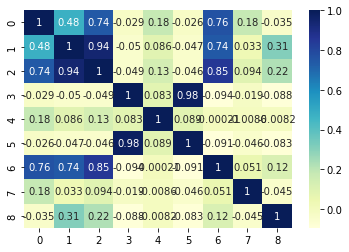

In [136]:
dataplot = sns.heatmap(cor_np, cmap="YlGnBu", annot=True)
  
plt.show()